# Convolutional Neural Network Based Optimization Approach for Wireless Resource Management 

This work is published a research article in IEEE Xplore: 
https://ieeexplore.ieee.org/document/9333532

This notebook requires:


---



1. wget
2. Tensorflow 1.x
3. Numpy
4. Scipy
5. Pandas
6. Matplotlib 3.2.2



Getting Training and Testing data from GitHub repository using **wget**

In [1]:
!wget -O "Train_data_10_100000.mat" "https://github.com/habiburrahman-mu/cnn-for-wireless-resource-allocation/raw/main/data/Train_data_10_100000.mat"
!wget -O "Test_data_10_10000.mat" "https://github.com/habiburrahman-mu/cnn-for-wireless-resource-allocation/raw/main/data/Test_data_10_10000.mat"

--2021-04-07 15:25:47--  https://github.com/habiburrahman-mu/cnn-for-wireless-resource-allocation/raw/main/data/Train_data_10_100000.mat
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/habiburrahman-mu/cnn-for-wireless-resource-allocation/main/data/Train_data_10_100000.mat [following]
--2021-04-07 15:25:48--  https://raw.githubusercontent.com/habiburrahman-mu/cnn-for-wireless-resource-allocation/main/data/Train_data_10_100000.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88000264 (84M) [application/octet-stream]
Saving to: ‘Train_data_10_100000.mat’

Train_data_10_10000 100%[==============

In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import scipy.io as sio
import numpy as np

import tensorflow as tf
import time

In [4]:
N = 10
num_train = 100000
num_test = 10000
epochs = 100
batch_size = 256
learning_rate = 0.0005

Load Training and Testing Data

In [5]:
load = sio.loadmat('Train_data_%d_%d.mat' % (N, num_train))
loadTest = sio.loadmat('Test_data_%d_%d.mat' % (N, num_test))
Htrain = load['Xtrain']
Ptrain = load['Ytrain']
H_test = loadTest['X']
P_test = loadTest['Y']
timeW = loadTest['swmmsetime']
swmmsetime = timeW[0, 0]

In [6]:
print("Shape of Htrain:", Htrain.shape)
print("Shape of Ptrain:", Ptrain.shape)

Shape of Htrain: (100000, 10, 10)
Shape of Ptrain: (100000, 10)


Single Data Representation

In [7]:
import pandas as pd
print(pd.DataFrame(Htrain[0]))

          0         1         2  ...         7         8         9
0  1.342613  0.422641  0.277836  ...  1.245724  1.411776  0.534078
1  0.486876  0.244248  0.827754  ...  0.315790  0.497679  1.640778
2  1.199419  0.608031  0.527158  ...  1.638226  1.007699  0.356301
3  0.682634  0.800450  1.224227  ...  1.400653  1.861390  0.352058
4  0.778598  0.373186  0.549773  ...  1.692597  0.275322  1.147785
5  1.352040  1.279353  0.154708  ...  0.643153  0.855599  1.092004
6  0.706990  1.379098  1.317143  ...  0.849232  0.786425  1.012927
7  1.206346  0.241728  0.100205  ...  0.653734  0.946538  1.342353
8  0.573377  0.688618  0.362665  ...  1.052734  1.096891  0.933573
9  0.433526  0.713767  0.765426  ...  0.761660  0.706572  0.349530

[10 rows x 10 columns]


In [8]:
print(pd.DataFrame(Ptrain[0]))

          0
0  1.000000
1  0.000019
2  0.009859
3  0.000004
4  1.000000
5  0.030497
6  1.000000
7  0.000102
8  1.000000
9  0.000005


Functions for calculating sum-rate

In [9]:
def IC_sum_rate(H, p, var_noise):
    H = np.square(H)
    fr = np.diag(H)*p
    ag = np.dot(H,p) + var_noise - fr
    y = np.sum(np.log(1+fr/ag) )
    return y
def np_sum_rate(X,Y):
    avg = 0
    n = X.shape[0]
    for i in range(n):
        avg += IC_sum_rate(X[i,:,:],Y[i,:],1)/n
    return avg

Further feature extraction from training data

In [10]:
def feature_extraction(H,num_train,N):
    H_ii = np.zeros((num_train,N))
    H_ij = np.zeros((num_train,N,N))
    H_ij_T = np.zeros((num_train,N,N))
    D = np.zeros((num_train,N,N))
    for ii in range(num_train):
        diag_H = np.diag(H[ii,:,:])
        for jj in range(N):
            H_ii[ii,jj] = H[ii,jj,jj]
            H_ij[ii,jj,:] = H[ii,:,jj].T
            H_ij[ii,jj,jj] = 0
            H_ij_T[ii,jj,:] = H[ii,jj,:]
            H_ij_T[ii,jj,jj] = 0
            D[ii,jj,:] = diag_H
            D[ii,jj,jj] = 0
    return H_ii, H_ij, H_ij_T, D

Define weights and biases of neural network

In [11]:
weights = {
    'w_c_1': tf.Variable(tf.random_normal([3, 3, 3, 32], stddev=0.1)),
    'w_c_2': tf.Variable(tf.random_normal([3, 3, 32, 32], stddev=0.1)),
    'w_c_3': tf.Variable(tf.random_normal([3, 3, 32, 16], stddev=0.1)),
    'w_c_4': tf.Variable(tf.random_normal([3, 3, 16, 6], stddev=0.1)),

    'w_fc_1': tf.Variable(tf.random_normal([12, 40], stddev=0.1)),
    'w_fc_2': tf.Variable(tf.random_normal([40, 20], stddev=0.1)),
    'w_fc_3': tf.Variable(tf.random_normal([20, 1])),
}

biases = {
    'b_c_1': tf.Variable(tf.random_normal([32], stddev=0.1)),
    'b_c_2': tf.Variable(tf.random_normal([32], stddev=0.1)),
    'b_c_3': tf.Variable(tf.random_normal([16], stddev=0.1)),
    'b_c_4': tf.Variable(tf.random_normal([6], stddev=0.1)),

    'b_fc_1': tf.Variable(tf.random_normal([40], stddev=0.1)),
    'b_fc_2': tf.Variable(tf.random_normal([20], stddev=0.1)),
    'b_fc_3': tf.Variable(tf.random_normal([1])),
}

### Neural Network

In [12]:
def network(input, weights, biases, strides = 1):
    conv1 = tf.nn.conv2d(input, weights['w_c_1'], strides=[1, strides, strides, 1], padding='SAME')
    conv1 = tf.nn.bias_add(conv1, biases['b_c_1'])
    relu1 = tf.nn.relu(conv1)

    conv2 = tf.nn.conv2d(relu1, weights['w_c_2'], strides=[1, strides, strides, 1], padding='SAME')
    conv2 = tf.nn.bias_add(conv2, biases['b_c_2'])
    relu2 = tf.nn.relu(conv2)

    conv3 = tf.nn.conv2d(relu2, weights['w_c_3'], strides=[1, strides, strides, 1], padding='SAME')
    conv3 = tf.nn.bias_add(conv3, biases['b_c_3'])
    relu3 = tf.nn.relu(conv3)

    conv4 = tf.nn.conv2d(relu3, weights['w_c_4'], strides=[1, strides, strides, 1], padding='SAME')
    conv4 = tf.nn.bias_add(conv4, biases['b_c_4'])
    relu4 = tf.nn.relu(conv4)

    sum_l = tf.reduce_sum(relu4, axis=2)
    max_l = tf.reduce_max(relu4, axis=2)

    concat = tf.concat([sum_l, max_l], axis=2)

    h1 = tf.tensordot(concat, weights['w_fc_1'], axes = [[2], [0]]) #tf.tensordot(a, b, axes)
    h1 = tf.add(h1, biases['b_fc_1'])
    h1 = tf.nn.relu(h1)

    h2 = tf.tensordot(h1, weights['w_fc_2'], axes=[[2], [0]])
    h2 = tf.add(h2, biases['b_fc_2'])
    h2 = tf.nn.relu(h2)

    out = tf.tensordot(h2, weights['w_fc_3'] ,axes = [[2], [0]])
    out = tf.add(out, biases['b_fc_3'])
    pred = tf.nn.sigmoid(out)
    
    return pred

In [13]:
H_ii, H_ij, H_ij_T, D = feature_extraction(Htrain,num_train,N)

Define tensors

In [14]:
X_ij = tf.placeholder(tf.float32, [None, N, N, 1]) 
X_ij_T = tf.placeholder(tf.float32, [None, N, N, 1])
X_D = tf.placeholder(tf.float32, [None, N, N, 1])
y = tf.placeholder(tf.float32, [None, N, 1])

In [15]:
inp = tf.concat((X_ij_T, X_ij, X_D), axis=3)
pred = network(inp, weights, biases)

Cost function and optimizer

In [16]:
cost2 = tf.reduce_mean(tf.square(pred - y)) #Mean Square Error
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Training and Validation data split

In [17]:
valid_split = 0.1
total_sample_size = num_train
validation_sample_size = int(total_sample_size*valid_split)
training_sample_size = total_sample_size - validation_sample_size

H_ii_train = np.reshape(H_ii[ 0:training_sample_size, :], (training_sample_size, N, 1))
H_ij_train = np.reshape(H_ij[ 0:training_sample_size, :, :], (training_sample_size, N, N, 1))
H_ij_T_train = np.reshape(H_ij_T[ 0:training_sample_size, :, :], (training_sample_size, N, N, 1))
D_train = np.reshape(D[ 0:training_sample_size, :, :], (training_sample_size, N, N, 1))

P_train = np.reshape(Ptrain[0:training_sample_size, :],  (training_sample_size, N, 1))

H_ii_val = np.reshape(H_ii[ training_sample_size:total_sample_size, :], (validation_sample_size, N, 1))
H_ij_val = np.reshape(H_ij[ training_sample_size:total_sample_size, :, :], (validation_sample_size, N, N, 1))
H_ij_T_val = np.reshape(H_ij_T[ training_sample_size:total_sample_size, :, :], (validation_sample_size, N, N, 1))
D_val = np.reshape(D[ training_sample_size:total_sample_size, :, :], (validation_sample_size, N, N, 1))

P_val = np.reshape(Ptrain[training_sample_size:total_sample_size, :],  (validation_sample_size, N, 1))

In [18]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
start_time = time.time()

MSETime=np.zeros((epochs, 3))

total_batch = int(total_sample_size / batch_size)

## Training

In [19]:
for epoch in range(epochs):
    for ii in range(total_batch):
        batch = np.random.randint(training_sample_size, size=batch_size)
        _, cost_value = sess.run([optimizer, cost2],
                                 feed_dict={X_ij: H_ij_train[batch, :, :], X_ij_T: H_ij_T_train[batch, :, :], X_D: D_train[batch, :, :], y: P_train[batch, :] })
        if (ii % 50 == 0):
            print("#", end='')
            # print('')

    cost_value2 = sess.run(cost2,
                           feed_dict={X_ij: H_ij_val, X_ij_T: H_ij_T_val, X_D: D_val, y: P_val})
    MSETime[epoch, 0] = cost_value
    MSETime[epoch, 1] = cost_value2
    MSETime[epoch, 2] = epoch + 1

    print("\n Epoch:", epoch + 1, "| Training:",cost_value, "| Validation:", cost_value2, "| Training Time:",time.time() - start_time)

########
 Epoch: 1 | Training: 0.07650599 | Validation: 0.0730113 | Training Time: 6.313860177993774
########
 Epoch: 2 | Training: 0.054811202 | Validation: 0.052334394 | Training Time: 10.429296731948853
########
 Epoch: 3 | Training: 0.05384739 | Validation: 0.05525615 | Training Time: 14.49223017692566
########
 Epoch: 4 | Training: 0.04796835 | Validation: 0.047708984 | Training Time: 18.56604528427124
########
 Epoch: 5 | Training: 0.057284378 | Validation: 0.052712772 | Training Time: 22.627798318862915
########
 Epoch: 6 | Training: 0.044232607 | Validation: 0.0402607 | Training Time: 26.69410490989685
########
 Epoch: 7 | Training: 0.04119687 | Validation: 0.04120961 | Training Time: 30.791965007781982
########
 Epoch: 8 | Training: 0.039533913 | Validation: 0.040481362 | Training Time: 34.83254384994507
########
 Epoch: 9 | Training: 0.040307716 | Validation: 0.04044563 | Training Time: 38.90142059326172
########
 Epoch: 10 | Training: 0.034693964 | Validation: 0.03945763 | T

Save training history

In [26]:
sio.savemat('CNN_MSE_%d_%d.mat'%(N, num_train), {'MSETime': MSETime})

Test data

In [27]:
H_ii_t, H_ij_t, H_ij_T_t, D_t = feature_extraction(H_test, num_test, N)
H_ii_t = np.reshape(H_ii_t, (num_test, N, 1))
H_ij_t = np.reshape(H_ij_t, (num_test, N, N, 1))
H_ij_T_t = np.reshape(H_ij_T_t, (num_test, N, N, 1))
D_t = np.reshape(D_t, (num_test, N, N, 1))
P_t = np.reshape(P_test,  (num_test, N, 1))

Prediction

In [28]:
start_time = time.time()
power = sess.run(pred, feed_dict={X_ij: H_ij_t, X_ij_T: H_ij_T_t, X_D: D_t, y: P_t})
loss = sess.run(cost2, feed_dict={X_ij: H_ij_t, X_ij_T: H_ij_T_t, X_D: D_t, y: P_t})
pred_time = time.time()-start_time
pred_y = np.reshape(power,(num_test,N))
print("Accuracy: %.3f%%" %((1-loss)*100))

sum_rate_cnn = np_sum_rate(H_test,pred_y)*np.log2(np.exp(1))
sum_rate_swmmse = np_sum_rate(H_test,P_test)*np.log2(np.exp(1))

print('Using CNN ----> Rate %f bps/Hz | Time: %f seconds' %(sum_rate_cnn, pred_time))
print('Using SWMMSE -> Rate %f bps/Hz | Time: %f seconds' %(sum_rate_swmmse, swmmsetime))
print("%f%% in %f%% time" % (sum_rate_cnn/sum_rate_swmmse*100, pred_time/swmmsetime*100))

Accuracy: 96.938%
Using CNN ----> Rate 2.562050 bps/Hz | Time: 0.197051 seconds
Using SWMMSE -> Rate 2.675865 bps/Hz | Time: 25.235367 seconds
95.746623% in 0.780851% time


Loss function plot

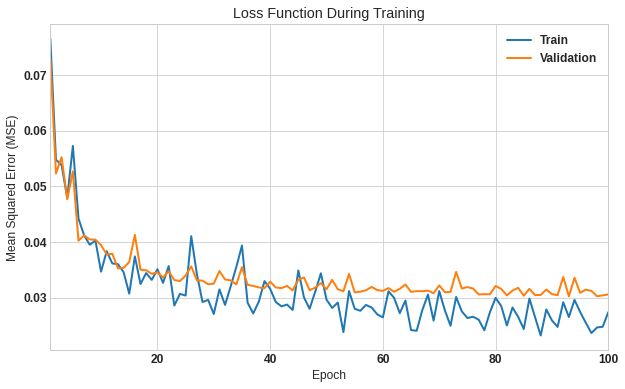

In [29]:
import matplotlib.pyplot as plt
MSETime = sio.loadmat('CNN_MSE_%d_%d.mat'%(N, num_train))['MSETime']
plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')
#print(MSETime[:,2].size)
font = {'family': 'sans-serif',
        'weight': 'bold',
        'size': 12}

plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('font', **font)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams.update({'legend.fontsize':12})
plt.plot(MSETime[:,2].T, MSETime[:,0].T,label='Train',  linewidth=2)
plt.plot(MSETime[:,2].T, MSETime[:,1].T,label='Validation', linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Loss Function During Training')
plt.xticks(np.arange(0, 101, step=20))      #10
plt.xlim(1, 100)
#plt.savefig('MSE_train.eps', format='eps', dpi=1000)
plt.show()

Distribution plot

In [30]:
num_sample = num_test
pyrate = np.zeros(num_sample)
nnrate = np.zeros(num_sample)
mprate = np.zeros(num_sample)
rdrate = np.zeros(num_sample)
nnrate_d = np.zeros(num_sample)
for i in range(num_sample):
    pyrate[i] = IC_sum_rate(H_test[i, :, :], pred_y[i, :], 1)*np.log2(np.exp(1))
    nnrate[i] = IC_sum_rate(H_test[i, :, :], pred_y[i, :], 1)*np.log2(np.exp(1))

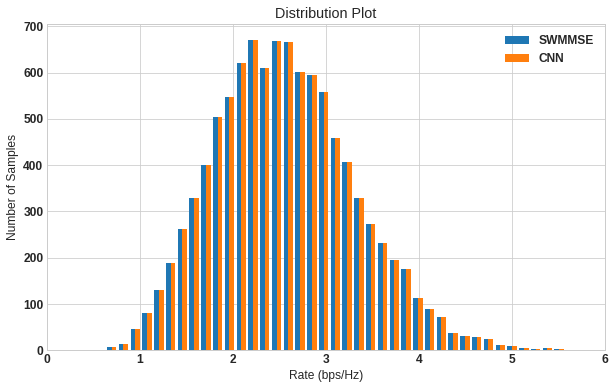

In [31]:
from matplotlib import rcParams

plt.figure(figsize=(10,6))
plt.style.use('seaborn-whitegrid')
#print(MSETime[:,2].size)
font = {'family': 'sans-serif',
        'weight': 'bold',
        'size': 12}

plt.rc('axes', labelsize=12)  # fontsize of the x and y labels
plt.rc('font', **font)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams.update({'legend.fontsize':12})
data = np.vstack([pyrate, nnrate]).T
bins = np.linspace(0, max(pyrate), 50)
plt.hist(data, bins, alpha=1, label=['SWMMSE', 'CNN'], )
plt.legend(loc='upper right')
plt.title('Distribution Plot')
plt.xlim([0, 6])
plt.xlabel('Rate (bps/Hz)')
plt.ylabel('Number of Samples')
plt.show()